In [1]:
import sys
sys.executable

'C:\\Users\\Paul\\anaconda3\\envs\\Master-Internship_Comp-Vis\\python.exe'

In [1]:
%pylab
%matplotlib inline

import re, isbi_seg_oak
from segmetrics.study     import *
from segmetrics.regional  import *
from segmetrics.boundary  import *
from segmetrics.detection import *
import segmetrics.parallel
from skimage import measure, io
import scipy.ndimage as ndi

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import socket

def get_version():
    import segmetrics
    return segmetrics.VERSION # this works

print('Last tested with version: %s (on host: %s)' % (get_version(), socket.gethostname()))

Last tested with version: 0.11.2 (on host: DESKTOP-0D2MQF6)


In [3]:
!conda list

# packages in environment at /home/void/.anaconda3/envs/kostrykin2021-amd:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       1_gnu    conda-forge
aiohttp                   3.7.4.post0              pypi_0    pypi
aiohttp-cors              0.7.0                    pypi_0    pypi
aioredis                  1.3.1                    pypi_0    pypi
anyio                     3.1.0            py38h578d9bd_0    conda-forge
appdirs                   1.4.4                      py_0    anaconda
argon2-cffi               20.1.0           py38h7b6447c_1    anaconda
async-timeout             3.0.1                    pypi_0    pypi
async_generator           1.10                       py_0    anaconda
attrs                     20.2.0                     py_0    anaconda
babel                     2.8.0                      py_0    anaconda
backcall               

In [6]:
def load_img(filepath):
    filepath = filepath.lower() 
    if filepath.endswith('.png'):
        return io.imread(filepath, 'gray') #in case we have a png image, just load
    elif filepath.endswith('.tif'):
        img = io.imread(filepath, plugin='tifffile')
        if img.ndim == 3:
            if img.shape[0] == 1: img = img[0] #if it's tif, it could have a weird first shape of 1 which we removed here. Otherweise tif is just loaded
            else: raise ValueError('not implemented')
        return img 
    else:
        raise ValueError('unknown file extension')

In [8]:
result_list      = [load_img('testdata/%02d_result.%s'      % (i, ext)) for i, ext in enumerate(['png', 'tif'], 1)]
groundtruth_list = [load_img('testdata/%02d_groundtruth.%s' % (i, ext)) for i, ext in enumerate(['png', 'tif'], 1)]
# so a list of groundtruths and a list of results I can produce on my own

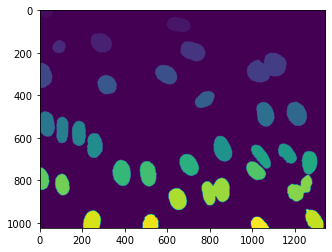

In [9]:
figure(); imshow(result_list[0])

## Testing `parallel` processing

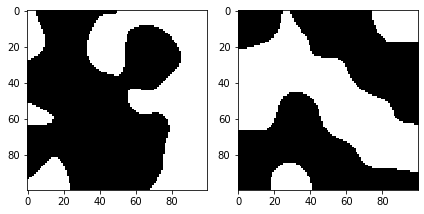

In [4]:
def create_parallel_testing_study(): # this chunk works
    study = Study()
    study.add_measure(ObjectBasedDistance(NSD()), 'NSD')
    study.add_measure(ISBIScore(), 'SEG')
    return study # whatever this is

def get_random_actual(chunk_id):
    random.seed(chunk_id)
    im = ndi.gaussian_filter(random.rand(100, 100), 10) # creating a random filter and subsetting to get the weird shape downstairs
    return im > im.mean() + 0.2 * im.std()

def get_random_expected(chunk_id):
    return get_random_actual(1000 + chunk_id)

subplot(121)
imshow(get_random_actual(1), 'gray', interpolation='none')
subplot(122)
imshow(get_random_expected(1), 'gray', interpolation='none')
tight_layout()

In [5]:
chunk_ids = range(11) # ??random isn't defined? Only here a problem because the other chunks below work
study     = create_parallel_testing_study()
for chunk_id in segmetrics.parallel.process(study, get_random_actual, get_random_expected, chunk_ids, num_forks=2, 
                                            is_actual_unique=False, is_expected_unique=False): #error here with random not being defined ???
    
    print('Finished chunk ID %d' % chunk_id)
    
print('')
study.print_results() #SEG is the ISBI score and NSD is the self-implemented object based metric with 

NameError: name 'random' is not defined

In [28]:
study2 = create_parallel_testing_study() 
for chunk_id in chunk_ids:
    study2.set_expected(get_random_expected(chunk_id), unique=False) # this pattern is seen often. so i give gt to study.set_expected
    study2.process(get_random_actual(chunk_id), unique=False, chunk_id=chunk_id) # and i give seg images to study.process. And this for each pair in a for loop
for measure_name in study.measures:
    assert  len(study[measure_name]) ==  len(study[measure_name])
    assert mean(study[measure_name]) == mean(study[measure_name])
    assert  std(study[measure_name]) ==  std(study[measure_name])

C:\Users\Paul\anaconda3\envs\Master-Internship_Comp-Vis\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Paul\anaconda3\envs\Master-Internship_Comp-Vis\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AssertionError: 

## Testing `Hausdorff` and `NSD`

Using **image-based distances**:

In [10]:
%%time  #this chunk works 
study = Study()

study.add_measure(NSD()                , 'NSD      ') #adding pixel-based distances I think. Not object
study.add_measure(Hausdorff(mode='a2e'), 'HSD (a2e)') #still not sure what Hausdorff makes
study.add_measure(Hausdorff(mode='e2a'), 'HSD (e2a)')
study.add_measure(Hausdorff(mode='sym'), 'HSD (sym)')

for groundtruth, result in zip(groundtruth_list, result_list):
    study.set_expected(groundtruth) # do like this
    study.process(result)

study.print_results()

HSD (a2e): 98.1446
HSD (e2a): 55.886
HSD (sym): 98.1446
NSD      : 21.89 %
Wall time: 1.46 s


Using **object-based distances**:

In [11]:
%%time # this chunk works but takes long but was expected 
study = Study() # but if it takes so long for 2 images.... then what for 92 images.... probably have to only use random subset or sth

study.add_measure(ObjectBasedDistance(NSD())                , 'NSD      ')
study.add_measure(ObjectBasedDistance(Hausdorff(mode='a2e')), 'HSD (a2e)')
study.add_measure(ObjectBasedDistance(Hausdorff(mode='e2a')), 'HSD (e2a)')
study.add_measure(ObjectBasedDistance(Hausdorff(mode='sym')), 'HSD (sym)')

for groundtruth, result in zip(groundtruth_list, result_list):
    study.set_expected(groundtruth)
    study.process(result)

study.print_results()

HSD (a2e): 5.40361
HSD (e2a): 29.5705
HSD (sym): 30.77
NSD      :  9.62 %
Wall time: 4min 37s


Using ***legacy* object-based distances**: (reproduces results prior to version 0.11)

In [12]:
%%time # this takes less time and is maybe more suited ??what's difference between legacy and normal??
study = Study()

study.add_measure(ObjectBasedDistance(                NSD(), skip_fn=True), 'NSD      ')
study.add_measure(ObjectBasedDistance(Hausdorff(mode='a2e'), skip_fn=True), 'HSD (a2e)')
study.add_measure(ObjectBasedDistance(Hausdorff(mode='e2a'), skip_fn=True), 'HSD (e2a)')
study.add_measure(ObjectBasedDistance(Hausdorff(mode='sym'), skip_fn=True), 'HSD (sym)')

for groundtruth, result in zip(groundtruth_list, result_list):
    study.set_expected(groundtruth)
    study.process(result)

study.print_results()

HSD (a2e): 4.83967
HSD (e2a): 29.4556
HSD (sym): 30.5281
NSD      :  9.14 %
Wall time: 15.7 s


## Testing the `detection` sub-module

In [19]:
study = Study()
study.add_measure(FalseSplit(), 'Split')
study.add_measure(FalseMerge(), 'Merge')
study.add_measure(FalsePositive(), 'FP')
study.add_measure(FalseNegative(), 'FN')

### No errors expected

   FN: 0
   FP: 0
Merge: 0
Split: 0


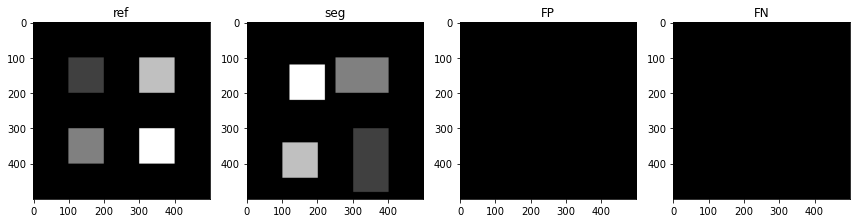

In [26]:
ref = zeros((500, 500), 'uint8')
ref[100:200, 100:200] = 1
ref[300:400, 100:200] = 2
ref[100:200, 300:400] = 3
ref[300:400, 300:400] = 4

seg = zeros((500, 500), 'uint8')
seg[120:220, 120:220] = 4 # doesn't matter if corresponding objects have the same or different labels
seg[340:440, 100:200] = 3
seg[100:200, 250:400] = 2
seg[300:480, 300:400] = 1

study.reset() # why reset???????????
study.set_expected(ref)
study.process(seg)
study.print_results()

figure(figsize=(12,4))
subplot(141)
imshow(ref, 'gray')
title('ref')
subplot(142)
imshow(seg, 'gray')
title('seg')
subplot(143)
imshow(study.measures['FP'].result, 'gray') # do like this ok ok
title('FP')
subplot(144)
imshow(study.measures['FN'].result, 'gray')
title('FN')
tight_layout()

assert all([sum(study[key]) == 0 for key in study.measures])

### False negative

<>:33: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:33: SyntaxWarning: "is not" with a literal. Did you mean "!="?


   FN: 1
   FP: 0
Merge: 0
Split: 0


<ipython-input-22-f807f8bc8f8a>:33: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  assert all([sum(study[key]) == 0 for key in study.measures if key is not 'FN'])


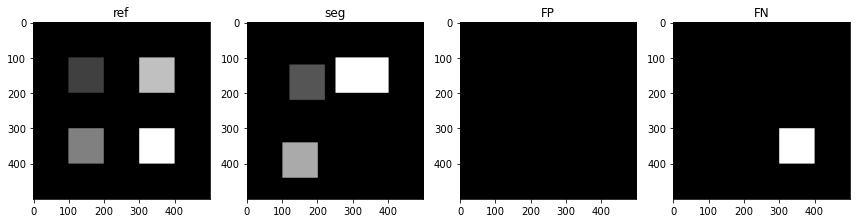

In [22]:
ref = zeros((500, 500), 'uint8')
ref[100:200, 100:200] = 1
ref[300:400, 100:200] = 2
ref[100:200, 300:400] = 3
ref[300:400, 300:400] = 4

seg = zeros((500, 500), 'uint8')
seg[120:220, 120:220] = 1
seg[340:440, 100:200] = 2
seg[100:200, 250:400] = 3

study.reset()
study.set_expected(ref)
study.process(seg)
study.print_results()

figure(figsize=(12,4))
subplot(141)
imshow(ref, 'gray')
title('ref')
subplot(142)
imshow(seg, 'gray')
title('seg')
subplot(143)
imshow(study.measures['FP'].result, 'gray')
title('FP')
subplot(144)
imshow(study.measures['FN'].result, 'gray')
title('FN')
tight_layout()

assert sum(study['FN']) == 1
assert all([sum(study[key]) == 0 for key in study.measures if key is not 'FN'])

<>:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-23-51bd2cbfa3c5>:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  assert all([sum(study[key]) == 0 for key in study.measures if key is not 'FN'])


   FN: 1
   FP: 0
Merge: 0
Split: 0


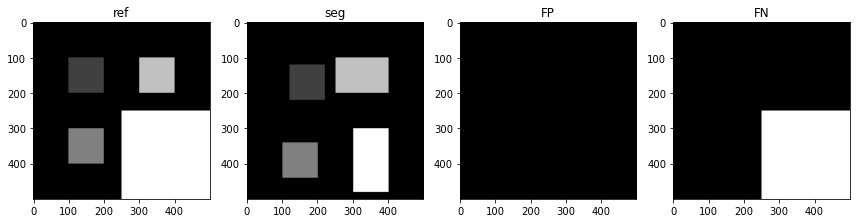

In [23]:
ref = zeros((500, 500), 'uint8')
ref[100:200, 100:200] = 1
ref[300:400, 100:200] = 2
ref[100:200, 300:400] = 3
ref[250:500, 250:500] = 4

seg = zeros((500, 500), 'uint8')
seg[120:220, 120:220] = 1
seg[340:440, 100:200] = 2
seg[100:200, 250:400] = 3
seg[300:480, 300:400] = 4

study.reset()
study.set_expected(ref)
study.process(seg)
study.print_results() # here the object is detected but only a small amount to it's seen as not detected

figure(figsize=(12,4))
subplot(141)
imshow(ref, 'gray')
title('ref')
subplot(142)
imshow(seg, 'gray')
title('seg')
subplot(143)
imshow(study.measures['FP'].result, 'gray')
title('FP')
subplot(144)
imshow(study.measures['FN'].result, 'gray')
title('FN')
tight_layout()

assert sum(study['FN']) == 1
assert all([sum(study[key]) == 0 for key in study.measures if key is not 'FN'])

<>:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-24-18f8ae1db76b>:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  assert all([sum(study[key]) == 0 for key in study.measures if key is not 'FN'])


   FN: 2
   FP: 0
Merge: 0
Split: 0


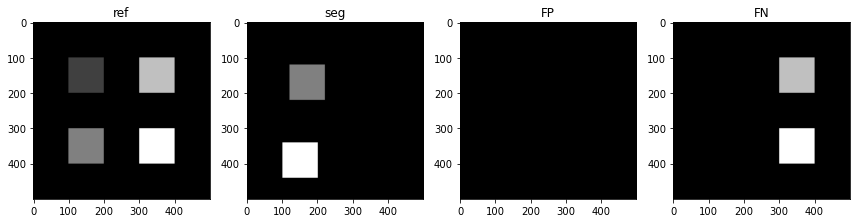

In [24]:
ref = zeros((500, 500), 'uint8')
ref[100:200, 100:200] = 1
ref[300:400, 100:200] = 2
ref[100:200, 300:400] = 3
ref[300:400, 300:400] = 4

seg = zeros((500, 500), 'uint8')
seg[120:220, 120:220] = 1
seg[340:440, 100:200] = 2

study.reset()
study.set_expected(ref)
study.process(seg)
study.print_results()

figure(figsize=(12,4))
subplot(141)
imshow(ref, 'gray')
title('ref')
subplot(142)
imshow(seg, 'gray')
title('seg')
subplot(143)
imshow(study.measures['FP'].result, 'gray')
title('FP')
subplot(144)
imshow(study.measures['FN'].result, 'gray')
title('FN')
tight_layout()

assert sum(study['FN']) == 2
assert all([sum(study[key]) == 0 for key in study.measures if key is not 'FN'])

### False positive

<>:33: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:33: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-17-530f3a70aa9f>:33: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  assert all([sum(study[key]) == 0 for key in study.measures if key is not 'FP'])


   FN: 0
   FP: 1
Merge: 0
Split: 0


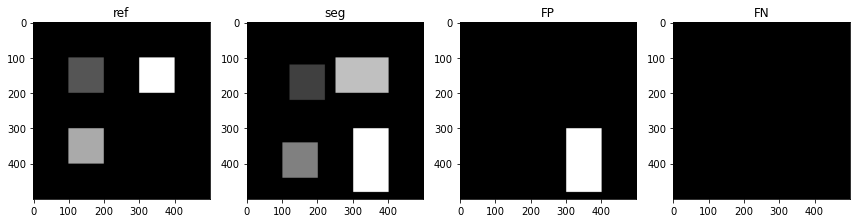

In [17]:
ref = zeros((500, 500), 'uint8')
ref[100:200, 100:200] = 1
ref[300:400, 100:200] = 2
ref[100:200, 300:400] = 3

seg = zeros((500, 500), 'uint8')
seg[120:220, 120:220] = 1
seg[340:440, 100:200] = 2
seg[100:200, 250:400] = 3
seg[300:480, 300:400] = 4

study.reset()
study.set_expected(ref)
study.process(seg)
study.print_results()

figure(figsize=(12,4))
subplot(141)
imshow(ref, 'gray')
title('ref')
subplot(142)
imshow(seg, 'gray')
title('seg')
subplot(143)
imshow(study.measures['FP'].result, 'gray')
title('FP')
subplot(144)
imshow(study.measures['FN'].result, 'gray')
title('FN')
tight_layout()

assert sum(study['FP']) == 1
assert all([sum(study[key]) == 0 for key in study.measures if key is not 'FP'])

<>:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-18-355564d0e52d>:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  assert all([sum(study[key]) == 0 for key in study.measures if key is not 'FP'])


   FN: 0
   FP: 1
Merge: 0
Split: 0


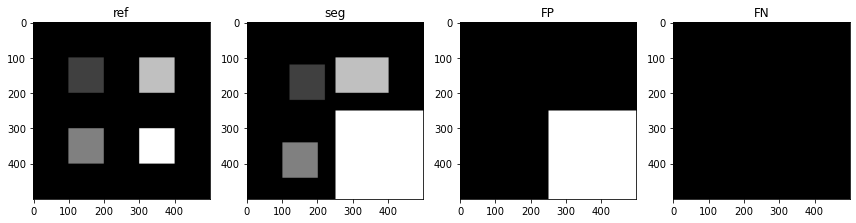

In [18]:
ref = zeros((500, 500), 'uint8')
ref[100:200, 100:200] = 1
ref[300:400, 100:200] = 2
ref[100:200, 300:400] = 3
ref[300:400, 300:400] = 4

seg = zeros((500, 500), 'uint8')
seg[120:220, 120:220] = 1
seg[340:440, 100:200] = 2
seg[100:200, 250:400] = 3
seg[250:500, 250:500] = 4

study.reset()
study.set_expected(ref)
study.process(seg)
study.print_results()

figure(figsize=(12,4))
subplot(141)
imshow(ref, 'gray')
title('ref')
subplot(142)
imshow(seg, 'gray')
title('seg')
subplot(143)
imshow(study.measures['FP'].result, 'gray')
title('FP')
subplot(144)
imshow(study.measures['FN'].result, 'gray')
title('FN')
tight_layout()

assert sum(study['FP']) == 1
assert all([sum(study[key]) == 0 for key in study.measures if key is not 'FP'])

<>:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-19-6f1fd39ad52a>:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  assert all([sum(study[key]) == 0 for key in study.measures if key is not 'FP'])


   FN: 0
   FP: 2
Merge: 0
Split: 0


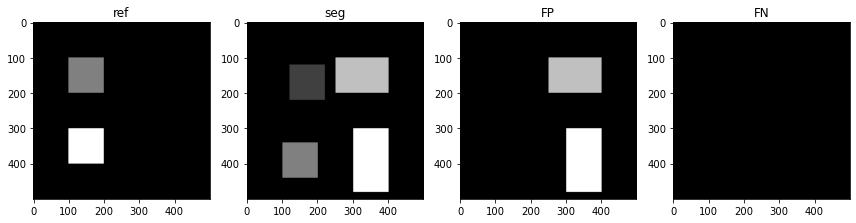

In [19]:
ref = zeros((500, 500), 'uint8')
ref[100:200, 100:200] = 1
ref[300:400, 100:200] = 2

seg = zeros((500, 500), 'uint8')
seg[120:220, 120:220] = 1
seg[340:440, 100:200] = 2
seg[100:200, 250:400] = 3
seg[300:480, 300:400] = 4

study.reset()
study.set_expected(ref)
study.process(seg)
study.print_results()

figure(figsize=(12,4))
subplot(141)
imshow(ref, 'gray')
title('ref')
subplot(142)
imshow(seg, 'gray')
title('seg')
subplot(143)
imshow(study.measures['FP'].result, 'gray')
title('FP')
subplot(144)
imshow(study.measures['FN'].result, 'gray')
title('FN')
tight_layout()

assert sum(study['FP']) == 2
assert all([sum(study[key]) == 0 for key in study.measures if key is not 'FP'])

### False merge

   FN: 0
   FP: 0
Merge: 1
Split: 0


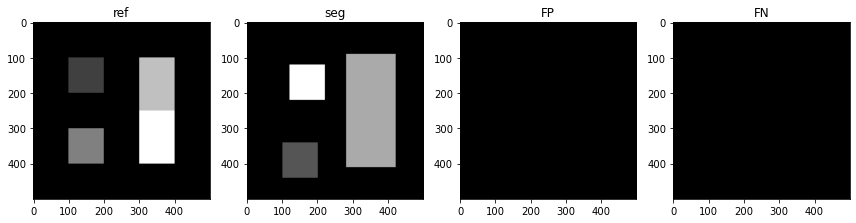

In [25]:
ref = zeros((500, 500), 'uint8')
ref[100:200, 100:200] = 1
ref[300:400, 100:200] = 2
ref[100:250, 300:400] = 3
ref[250:400, 300:400] = 4

seg = zeros((500, 500), 'uint8')
seg[120:220, 120:220] = 3
seg[340:440, 100:200] = 1
seg[ 90:410, 280:420] = 2

study.reset()
study.set_expected(ref)
study.process(seg)
study.print_results() #false merge useful so see if objects are in groundtruth separate

figure(figsize=(12,4))
subplot(141)
imshow(ref, 'gray')
title('ref')
subplot(142)
imshow(seg, 'gray')
title('seg')
subplot(143)
imshow(study.measures['FP'].result, 'gray')
title('FP')
subplot(144)
imshow(study.measures['FN'].result, 'gray')
title('FN')
tight_layout()

assert sum(study['Merge']) == 1
assert all([sum(study[key]) == 0 for key in study.measures if key != 'Merge'])

   FN: 0
   FP: 1
Merge: 1
Split: 0


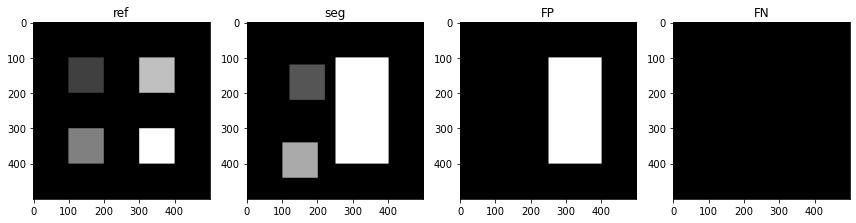

In [21]:
ref = zeros((500, 500), 'uint8')
ref[100:200, 100:200] = 1
ref[300:400, 100:200] = 2
ref[100:200, 300:400] = 3
ref[300:400, 300:400] = 4

seg = zeros((500, 500), 'uint8')
seg[120:220, 120:220] = 1
seg[340:440, 100:200] = 2
seg[100:400, 250:400] = 3

study.reset()
study.set_expected(ref)
study.process(seg)
study.print_results()

figure(figsize=(12,4))
subplot(141)
imshow(ref, 'gray')
title('ref')
subplot(142)
imshow(seg, 'gray')
title('seg')
subplot(143)
imshow(study.measures['FP'].result, 'gray')
title('FP')
subplot(144)
imshow(study.measures['FN'].result, 'gray')
title('FN')
tight_layout()

assert sum(study['Merge']) == 1
assert sum(study[   'FP']) == 1
assert all([sum(study[key]) == 0 for key in study.measures if key != 'Merge' and key != 'FP'])

   FN: 0
   FP: 2
Merge: 1
Split: 0


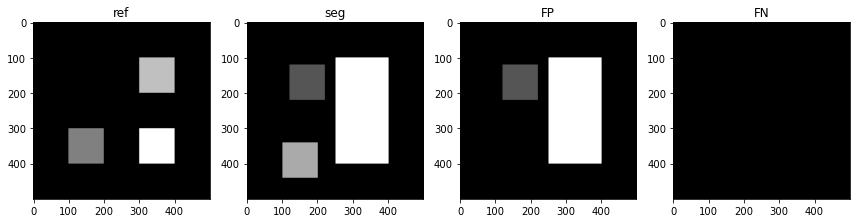

In [22]:
ref = zeros((500, 500), 'uint8')
ref[300:400, 100:200] = 2
ref[100:200, 300:400] = 3
ref[300:400, 300:400] = 4

seg = zeros((500, 500), 'uint8')
seg[120:220, 120:220] = 1
seg[340:440, 100:200] = 2
seg[100:400, 250:400] = 3

study.reset()
study.set_expected(ref)
study.process(seg)
study.print_results()

figure(figsize=(12,4))
subplot(141)
imshow(ref, 'gray')
title('ref')
subplot(142)
imshow(seg, 'gray')
title('seg')
subplot(143)
imshow(study.measures['FP'].result, 'gray')
title('FP')
subplot(144)
imshow(study.measures['FN'].result, 'gray')
title('FN')
tight_layout()

assert sum(study['Merge']) == 1
assert sum(study[   'FP']) == 2
assert all([sum(study[key]) == 0 for key in study.measures if key != 'Merge' and key != 'FP'])

### False split

   FN: 0
   FP: 0
Merge: 0
Split: 1


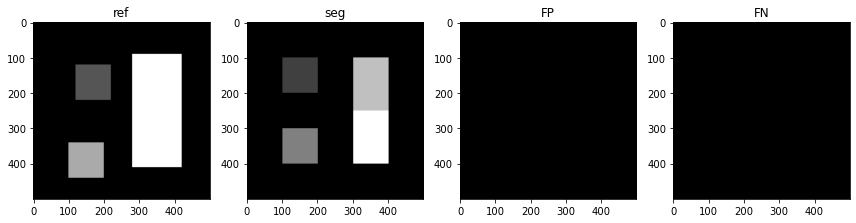

In [23]:
ref = zeros((500, 500), 'uint8')
ref[120:220, 120:220] = 1
ref[340:440, 100:200] = 2
ref[ 90:410, 280:420] = 3

seg = zeros((500, 500), 'uint8')
seg[100:200, 100:200] = 1
seg[300:400, 100:200] = 2
seg[100:250, 300:400] = 3
seg[250:400, 300:400] = 4

study.reset()
study.set_expected(ref)
study.process(seg)
study.print_results()

figure(figsize=(12,4))
subplot(141)
imshow(ref, 'gray')
title('ref')
subplot(142)
imshow(seg, 'gray')
title('seg')
subplot(143)
imshow(study.measures['FP'].result, 'gray')
title('FP')
subplot(144)
imshow(study.measures['FN'].result, 'gray')
title('FN')
tight_layout()

assert sum(study['Split']) == 1
assert all([sum(study[key]) == 0 for key in study.measures if key != 'Split'])

   FN: 1
   FP: 0
Merge: 0
Split: 1


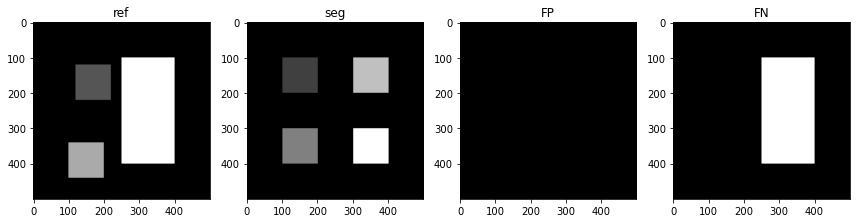

In [24]:
ref = zeros((500, 500), 'uint8')
ref[120:220, 120:220] = 1
ref[340:440, 100:200] = 2
ref[100:400, 250:400] = 3 #object very large and not captured enough by two seg objects so FN

seg = zeros((500, 500), 'uint8')
seg[100:200, 100:200] = 1
seg[300:400, 100:200] = 2
seg[100:200, 300:400] = 3
seg[300:400, 300:400] = 4

study.reset()
study.set_expected(ref)
study.process(seg)
study.print_results()

figure(figsize=(12,4))
subplot(141)
imshow(ref, 'gray')
title('ref')
subplot(142)
imshow(seg, 'gray')
title('seg')
subplot(143)
imshow(study.measures['FP'].result, 'gray')
title('FP')
subplot(144)
imshow(study.measures['FN'].result, 'gray')
title('FN')
tight_layout()

assert sum(study['Split']) == 1
assert sum(study[   'FN']) == 1
assert all([sum(study[key]) == 0 for key in study.measures if key != 'Split' and key != 'FN'])

   FN: 2
   FP: 0
Merge: 0
Split: 1


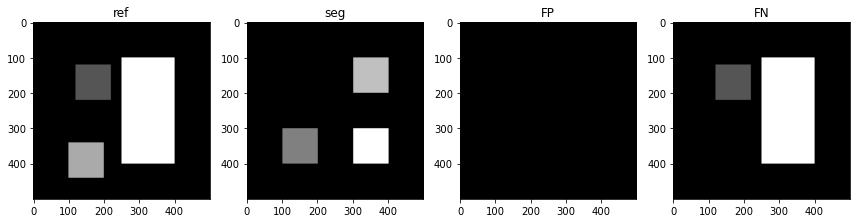

In [25]:
ref = zeros((500, 500), 'uint8')
ref[120:220, 120:220] = 1
ref[340:440, 100:200] = 2
ref[100:400, 250:400] = 3

seg = zeros((500, 500), 'uint8')
seg[300:400, 100:200] = 2
seg[100:200, 300:400] = 3
seg[300:400, 300:400] = 4

study.reset()
study.set_expected(ref)
study.process(seg)
study.print_results()

figure(figsize=(12,4))
subplot(141)
imshow(ref, 'gray')
title('ref')
subplot(142)
imshow(seg, 'gray')
title('seg')
subplot(143)
imshow(study.measures['FP'].result, 'gray')
title('FP')
subplot(144)
imshow(study.measures['FN'].result, 'gray')
title('FN')
tight_layout()

assert sum(study['Split']) == 1
assert sum(study[   'FN']) == 2
assert all([sum(study[key]) == 0 for key in study.measures if key != 'Split' and key != 'FN'])

## Testing the `RandIndex` Implementation

In [26]:
random.seed(3)
R = random.rand(40, 40).round().astype(int)
S = random.rand(40, 40).round().astype(int)

a, b, c, d = 0, 0, 0, 0
for i in xrange(len(R.flat)):
    for j in xrange(i + 1, len(R.flat)):
        if   R.flat[i] == R.flat[j] and S.flat[i] == S.flat[j]: a += 2
        elif R.flat[i] != R.flat[j] and S.flat[i] == S.flat[j]: b += 2
        elif R.flat[i] == R.flat[j] and S.flat[i] != S.flat[j]: c += 2
        elif R.flat[i] != R.flat[j] and S.flat[i] != S.flat[j]: d += 2

rand_index_impl = RandIndex()
rand_index_impl.set_expected(R)
parts = rand_index_impl.compute_parts(S)

assert a == parts[0] and b == parts[1] and c == parts[2] and d == parts[3]

## Performance of ISBI SEG Score

In [28]:
%%timeit
study = Study()
study.add_measure(ISBIScore())
study.set_expected(groundtruth_list[0])
study.process(result_list[0])
study.print_results()

2181246991280: 75.19 %
2181238715488: 75.19 %
2181243834528: 75.19 %
2181243834528: 75.19 %
2181243834528: 75.19 %
2181243677760: 75.19 %
2181243677760: 75.19 %
2181243677760: 75.19 %
392 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Gauging of ISBI SEG Score

In [28]:
seterr(all='raise');

In [29]:
study = Study()

study.add_measure(Dice()             , 'Dice'   )
study.add_measure(NSD()              , 'NSD'    )
study.add_measure(ISBIScore()        , 'SEG'    )
study.add_measure(RandIndex()        , 'Rand'   )
study.add_measure(AdjustedRandIndex(), 'ARI'    )
study.add_measure(JaccardIndex()     , 'Jaccard')

study.add_measure(Hausdorff(mode='sym'), 'Hausdorff (sym)') # Hausdorff has so many modes bruuuuh
study.add_measure(Hausdorff(mode='a2e'), 'Hausdorff (a2e)')
study.add_measure(Hausdorff(mode='e2a'), 'Hausdorff (e2a)')

for groundtruth, result in zip(groundtruth_list, result_list):
    study.set_expected(groundtruth)
    study.process(result)

study.print_results()

            ARI: 86.47 %
           Dice: 90.65 %
Hausdorff (a2e): 98.1446
Hausdorff (e2a): 55.886
Hausdorff (sym): 98.1446
        Jaccard: 2.54111
            NSD: 21.89 %
           Rand: 92.03 %
            SEG: 79.99 %


In [30]:
def get_official_isbi_seg_score(groundtruth_list, result_list):
    oak_result = isbi_seg_oak.oak(groundtruth_list, result_list).decode('utf-8')
    match = re.compile(r'.*?([\.0-9]+)').match(oak_result)
    if match is not None:
        official_result = float(match.group(1))
        return official_result
    else:
        raise ValueError('Unexpected result:', oak_result)

print('Error:', get_official_isbi_seg_score(groundtruth_list, result_list) - mean(study['SEG']))

/home/void/Documents/segmetrics.py/isbi_seg_oak.py:19: UserWarning: data/01_RES/mask000.tif is a low contrast image
  io.imsave('data/01_RES/mask%03d.tif'       % i, result     [None, :, :].astype('uint16'), plugin='tifffile')
/home/void/Documents/segmetrics.py/isbi_seg_oak.py:20: UserWarning: data/01_GT/SEG/man_seg000.tif is a low contrast image
  io.imsave('data/01_GT/SEG/man_seg%03d.tif' % i, groundtruth[None, :, :].astype('uint16'), plugin='tifffile')
/home/void/Documents/segmetrics.py/isbi_seg_oak.py:19: UserWarning: data/01_RES/mask001.tif is a low contrast image
  io.imsave('data/01_RES/mask%03d.tif'       % i, result     [None, :, :].astype('uint16'), plugin='tifffile')
/home/void/Documents/segmetrics.py/isbi_seg_oak.py:20: UserWarning: data/01_GT/SEG/man_seg001.tif is a low contrast image
  io.imsave('data/01_GT/SEG/man_seg%03d.tif' % i, groundtruth[None, :, :].astype('uint16'), plugin='tifffile')


Error: 2.3291596751295884e-07


Passing `unique=False` to `Study.set_expected` should not affect the result of the *first* image, that is already labeled uniquely:

In [31]:
studies2 = [Study(), Study()]
for measure in study.measures.items():
    for s in studies2: s.add_measure(*measure[::-1])

studies2[0].set_expected(groundtruth_list[0], unique=True)
studies2[0].process(result_list[0])

studies2[1].set_expected(groundtruth_list[0], unique=False)
studies2[1].process(result_list[0])

for measure_name in study.measures.keys():
    assert allclose(studies2[0][measure_name], studies2[1][measure_name])

## Dealing with Non-unique Labels and ISBI SEG Score

In [32]:
print('%s to %s' % (result_list[1].min()     , result_list[1].max()     ))
print('%s to %s' % (groundtruth_list[1].min(), groundtruth_list[1].max()))

0 to 426
0 to 348


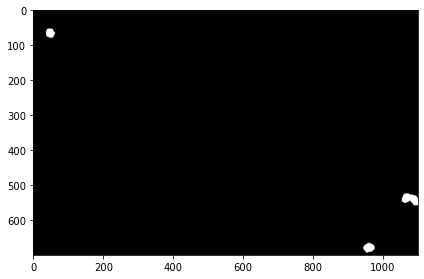

In [33]:
imshow(groundtruth_list[1] == 1, 'gray')
tight_layout()

In [34]:
official_result = get_official_isbi_seg_score([groundtruth_list[1]], [result_list[1]])
print(official_result)

/home/void/Documents/segmetrics.py/isbi_seg_oak.py:19: UserWarning: data/01_RES/mask000.tif is a low contrast image
  io.imsave('data/01_RES/mask%03d.tif'       % i, result     [None, :, :].astype('uint16'), plugin='tifffile')
/home/void/Documents/segmetrics.py/isbi_seg_oak.py:20: UserWarning: data/01_GT/SEG/man_seg000.tif is a low contrast image
  io.imsave('data/01_GT/SEG/man_seg%03d.tif' % i, groundtruth[None, :, :].astype('uint16'), plugin='tifffile')


0.805115


Test *without* relabling the ground truth:

In [35]:
study = Study()
study.add_measure(ISBIScore())

study.set_expected(groundtruth_list[1])
study.process(result_list[1])

our_result = mean(study[list(study.measures.keys())[0]])
print(our_result - official_result)

1.618582974316496e-07


Test *with* relabling the ground truth:

In [36]:
study = Study()
study.add_measure(ISBIScore())

study.set_expected(groundtruth_list[1], unique=False)
study.process(result_list[1])

our_result = mean(study[list(study.measures.keys())[0]])
print(our_result - official_result)

0.009435157718938436


So in order to immitate the official evaluation software, we must not relabel the ground truth.

## Datatype Tests

In [37]:
def test_dtypes(result_dtype, gt_dtype, unique=True):
    result      = load_img('testdata/01_result.png').astype(result_dtype)
    groundtruth = load_img('testdata/01_groundtruth.png').astype(gt_dtype)

    study = Study()
    study.add_measure(ISBIScore(), 'isbi')

    study.set_expected(groundtruth, unique=unique)
    study.process(result)

    print('%s, %s' % (groundtruth.dtype, result.dtype))
    print(mean(study['isbi']))

test_dtypes('uint8', 'uint8')

uint8, uint8
0.7519281991705565


In [38]:
test_dtypes(int, int)

int64, int64
0.7519281991705565


In [39]:
try:
    test_dtypes(float, int)
    assert False
except AssertionError as ex:
    assert str(ex) == 'illegal image dtype', ex

In [40]:
try:
    test_dtypes(int, bool)
    assert False
except AssertionError as ex:
    assert str(ex) == 'with unique=True a non-boolean ground truth is expected', ex

In [41]:
test_dtypes(int, bool, unique=False) # unique for my gts is true because they labeled but for my segments it's false because binary

bool, int64
0.7519281991705565


In [42]:
try:
    test_dtypes(int, float)
    assert False
except AssertionError as ex:
    assert str(ex) == 'illegal ground truth dtype', ex

In [43]:
try:
    test_dtypes(bool, float)
    assert False
except AssertionError as ex:
    assert str(ex) == 'illegal ground truth dtype', ex

## Test GT vs. GT

In [29]:
groundtruth = load_img('testdata/01_groundtruth.png')

study = Study()
study.add_measure(ISBIScore(), 'isbi')

study.set_expected(groundtruth)
study.process(groundtruth)

assert allclose(1, mean(study['isbi']))

In [30]:
groundtruth = load_img('testdata/01_groundtruth.png')

study = Study()
study.add_measure(ISBIScore(), 'isbi')

study.set_expected(groundtruth, unique=False) #this time unique to false
study.process(groundtruth) # lol here gt too

assert allclose(1, mean(study['isbi']))

In [31]:
groundtruth = (load_img('testdata/01_groundtruth.png') > 0).astype(int)

study = Study()
study.add_measure(ISBIScore(), 'isbi')

study.set_expected(groundtruth, unique=False) # this time false for both 
study.process(groundtruth, unique=False)

assert allclose(1, mean(study['isbi']))